In [2]:
#include <iostream>

/*a workaround to solve cling issue*/
#include "../inc/macos_cling_workaround.hpp"
/*set libtorch path, load libs*/
#include "../inc/load_libtorch.hpp"
/*import custom defined macros*/
#include "../inc/custom_def.hpp"
/*import matplotlibcpp*/
#include "../inc/load_matplotlibcpp.hpp"
/*import opencv*/
#include "../inc/load_opencv.hpp"

/*import libtorch header file*/
#include <torch/torch.h>
#include <opencv2/opencv.hpp>

# 加载图像分类数据集：Fasion-MNIST

libtorch中没有类似公开课上使用的torchvision的c++ API，不过可以使用原生的mnist API来代替：

### 构造datasets

In [3]:
// Create a multi-threaded data loader for the Fashion-MNIST dataset.
auto data_set = torch::data::datasets::MNIST("../dataset/fashion_mnist");

torch::Tensor images  = data_set.images();
torch::Tensor targets = data_set.targets();

/*打印一下数据集的大小，共60000个图像样本，每个图像均是1通道灰度图，大小是28 x 28像素*/
printT(images.sizes());
/*图像数据的数据类型是float！*/
printT(images.dtype());
/*对应数据集的，共有60000个标注*/
printT(targets.sizes());
/*label的数据类型是long int*/
printT(targets.dtype());

images.sizes() = 
[60000, 1, 28, 28]
<<--->>

images.dtype() = 
float
<<--->>

targets.sizes() = 
[60000]
<<--->>

targets.dtype() = 
long long
<<--->>



### 构造 data_loader，用于数据采样 

In [4]:
auto data_loader = torch::data::make_data_loader(data_set.map(
      torch::data::transforms::Stack<>()), /*batch_size=*/12);

// auto batch_0 = (*data_loader)[0]; 
auto batch_iter = data_loader->begin();
auto images0 = (*batch_iter).data;
auto labels0 = (*batch_iter).target;

/*看一下每个batch的大小*/
printT(images0.sizes());
printT(labels0.sizes());

images0.sizes() = 
[12, 1, 28, 28]
<<--->>

labels0.sizes() = 
[12]
<<--->>



# Show 图

In [5]:
std::string text_labels[10] = { "t-shirt", "trouser", 
                                "pullover", "dress", 
                                "coat", "sandal", 
                                "shirt", "sneaker", 
                                "bag", "ankle boot"
                               };

In [6]:
/****************************************
 * 显示图片的程序
 * 受到xeus-cling的限制，无法使用像 ‘matplotlib’ 这样
 * 的包在notebook中嵌入式显示，因此此处借助 opencv 先将
 * 图片保存，然后借助xeus-cling的rich display机制来
 * 将图片嵌入显示在notebook中，后续会考虑使用其它插件
 * 来完善图片显示功能。
 *****************************************/
void show_one_image(torch::Tensor image, torch::Tensor label, std::string labeltxt[])
{
    int idx = label[0].item<int>();
    std::string label_name = labeltxt[idx];
    cv::Mat img(28, 28, CV_8UC1);
    std::memcpy((void*)img.data, image.data_ptr(), sizeof(torch::kU8)*image.numel());
    cv::imwrite("test.png", img);
}

In [7]:
void show_images(std::vector<torch::Tensor> images, std::vector<torch::Tensor> labels, std::string labeltxt[])
{
    auto a = images;
    auto b = labels;

    torch::Tensor image1, image2, label;
    std::string s1, s2;
    for (int i = 0; i < a.size()/2; i++) {
        torch::Tensor t1 = a[i].squeeze();
        torch::Tensor t2 = a[i+1].squeeze();
        if (image1.numel() == 0) {
            image1 = t1.clone();
            s1 = labeltxt[b[i].item<int>()] + "\t\t";
        } else {
            image1 = torch::cat({image1, t1}, 1);
            s1 += labeltxt[b[i].item<int>()];
            s1 += "\t\t";
        }

        if (image2.numel() == 0) {
            image2 = t2.clone();
            s2 = labeltxt[b[i+1].item<int>()] + "\t\t";
        } else {
            image2 = torch::cat({image2, t2}, 1);
            s2 += labeltxt[b[i+1].item<int>()];
            s2 += "\t\t";
        }
    }
    
//     for (int i = 0; i < b.size()/2; i++) {
//         int idx = b[i * 2].item<int>();
//         std::cout << labeltxt[idx] << "\t";
//     }
//     std::cout << std::endl;
    
//     for (int i = 0; i < b.size()/2; i++) {
//         int idx = b[i * 2 + 1].item<int>();
//         std::cout << labeltxt[idx] << "\t";
//     }
//     std::cout << std::endl;
    
    std::cout << s1 << std::endl;
    std::cout << s2 << std::endl;
    torch::Tensor image = torch::cat({image1, image2}, 0);
    image *= 255;
    image = torch::clamp(image, 0, 255);
    // 原数据类型为float，为适应cv Mat的数据类型（CV_8UC1），需要转换为unsigned char;
    image = image.to(torch::kU8);
    cv::Mat img(image.size(0), image.size(1), CV_8UC1);
    std::memcpy((void*)img.data, image.data_ptr(), sizeof(torch::kU8)*image.numel());
    cv::imwrite("test.png", img);
}

In [8]:
/* **
 * images0是batch tensor，是一个四维tensor，其大小为batch_size x channel x height x width
 * 使用chunk()将其拆散为batch_size个独立tensor，每个tensor是一幅独立图片，然后将这些tensor再组合
 * 成一个vector<torch::Tensor>;
 */
auto a = torch::chunk(images0, images0.size(0));
auto b = torch::chunk(labels0, labels0.size(0));

// 取出其中第一幅图像，其大小为 1 x 28 x 28，其中1是通道数
auto image = a[0].clone();
auto label = b[0].clone();

// printT(image.sizes());
// 使用squeeze()去除那些大小为1的维度，这里，会把图片的通道维度消除掉，仅剩下长、宽；
// permute()函数用于交换不同维度的顺序，这里用不到，如果是3通道图像，tensor的格式为
// C X H X W，此时需要借助permute()将其变为 H X W X C;
image = image.squeeze();//.permute({1,2,0});
// 因为在处理前对cvmat中的值做了归一化，所以现在要*255恢复，同时对于不在0-255范围内的数据，需要做限制
image *= 255;
image = torch::clamp(image, 0, 255);
// 原数据类型为float，为适应cv Mat的数据类型（CV_8UC1），需要转换为unsigned char;
image = image.to(torch::kU8);

// printT(image);

coat		trouser		trouser		sandal		dress		sneaker		
trouser		trouser		sandal		dress		sneaker		shirt		


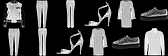

In [9]:
show_images(a, b, text_labels);
auto simg = im::image("test.png");
simg

In [10]:
// 调用函数show图
show_one_image(image, label, text_labels);

auto simg = im::image("test.png");
simg